# Project: Dự Đoán Giá Bán Nhà Bằng Linear Regression

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

In [33]:
sale_houses = pd.read_csv('AmesHousing.txt',delimiter = '\t')

In [4]:
print(sale_houses.shape)
sale_houses.head()

(2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
#Tạo những hàm cần thiết để layout trước bố cục những việc cần làm
def transform_features(df):
    return df

def select_features(df):
    return df.loc[:,['Gr Liv Area','SalePrice']]

def train_and_test(df):
    train = df[0:1460].copy()
    test = df[1460:].copy()
    
    X_train = select_features(train).iloc[:,:-1]
    y_train = select_features(train).iloc[:,-1]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    X_test = select_features(test).iloc[:,:-1]
    y_test = select_features(test).iloc[:,-1]
    
    y_predict = lr.predict(X_test)
    
    mse_test = mean_squared_error(y_predict,y_test)
    rmse_test = np.sqrt(mse_test)
    
    return rmse_test

In [35]:
RMSE = train_and_test(sale_houses)
RMSE

57088.25161263909

- Kết Luận 1: Với việc chỉ chọn 1 column 'Gr Liv Area' làm features và không làm gì thêm ta có RMSE = 57088.25161263909
- Nhiệm vụ của project: hãy dùng tất cả phương pháp transform features, select feature ... để tối ưu hóa trước khi train model, cụ thể expect RMSE phải giảm đáng kể so với RMSE ở trên.


# Transform Features

- Handle missing values:
    - Missing values  > 5%:
        - Drop any columns with 5% or more missing values for now.
    - Missing values  < 5%:
        -  Text columns:
            - Drop any with 1 or more missing values for now.
        -  Numerical columns:
            - For columns with missing values: fillna

1. Drop tất cả các columns có số lượng missing value > 5%

In [54]:
seri_null_counts = sale_houses.isnull().sum()
index_null_than5 = seri_null_counts[seri_null_counts>(len(sale_houses)/20)].index
drop_null_than5 = sale_houses.drop(columns = index_null_than5, axis = 1)
drop_null_than5.shape

(2930, 71)

2. Đối với text columns: drop column nếu chứa chỉ 1 missing values hoặc nhiều hơn

In [55]:
text_null_counts = drop_null_than5.select_dtypes(include = 'object').isnull().sum()
text_null_index = text_null_counts[text_null_counts > 0].index
data = drop_null_than5.drop(columns =text_null_index, axis = 1 )
data.shape

(2930, 64)

3. Đối với numeric columns: 
- Fillna = mean đối với những giá trị null.
- Điều này sẽ không làm hỏng model hay sai dữ liệu bởi vì những numeric_column này có số lượng null rất ít ( <5% do kết quả từ bước 1)

In [56]:
# show numeric_colums counts:
data.select_dtypes(include = ['float','int']).isnull().sum().value_counts()

0     28
1      6
2      2
23     1
dtype: int64

In [57]:
#fillna for numeric_col
cols_num = data.select_dtypes(include = ['float','int']).columns
data.loc[:,cols_num] = data.loc[:,cols_num].fillna(data.loc[:,cols_num].mean())
# Verify that every column has 0 missing values
data.isnull().sum().value_counts()

0    64
dtype: int64

4. Khám phá những column thời gian sau
- 'Year Built' là năm xây dựng
- 'Yr Sold' là năm bán
- 'Year Remod/Add' là năm tu sửa
- Bây giờ hãy cố gắng tạo ra những tính năng mới có ý nghĩa hơn từ 3 column trên giúp ích cho model:
    - Project này là dự đoán giá bán SalePrice nên rất hữu ích khi biết:
        - 1.thời gian từ năm xây đến năm bán ( tuổi của căn nhà )
        - 2.thời gian từ năm tu sửa đến năm bán.

In [58]:
#Tạo 2 feature mới và sau đó tìm điểm dữ liệu error của chúng:
data['Years Before Sale'] = data['Yr Sold'] - data['Year Built']
age_error = data['Years Before Sale'][data['Years Before Sale']<0].index.to_list()
print(data['Years Before Sale'][data['Years Before Sale']<0])

print('----------')

data['Years Since Remod'] = data['Yr Sold'] - data['Year Remod/Add']
remod_error = data['Years Since Remod'][data['Years Since Remod'] <0].index.to_list()
print(data['Years Since Remod'][data['Years Since Remod'] <0])

2180   -1
Name: Years Before Sale, dtype: int64
----------
1702   -1
2180   -2
2181   -1
Name: Years Since Remod, dtype: int64


In [59]:
list_error = list(set(age_error + remod_error))
list_error

[2180, 2181, 1702]

In [60]:
data.loc[list_error,['Year Built','Year Remod/Add','Yr Sold']]

,Year Built,Year Remod/Add,Yr Sold
2180,2008,2009,2007
2181,2007,2008,2007
1702,2007,2008,2007


In [61]:
# drop những rows error
data = data.drop(list_error, axis =0)
#drop 2 column không còn dùng đến
data = data.drop(["Year Built", "Year Remod/Add"], axis = 1)

5. Drop columns that
- that aren't useful for ML
- leak data about the final sale, read more about columns

In [62]:
## Drop columns that aren't useful for ML
data = data.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
data = data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

6. For now, Let's update transform_features()

In [67]:
def transform_features(df):
    seri_null_counts = df.isnull().sum()
    index_null_than5 = seri_null_counts[seri_null_counts>(len(sale_houses)/20)].index
    drop_null_than5 = df.drop(columns = index_null_than5, axis = 1)
    
    text_null_counts = drop_null_than5.select_dtypes(include = 'object').isnull().sum()
    text_null_index = text_null_counts[text_null_counts > 0].index
    data = drop_null_than5.drop(columns =text_null_index, axis = 1 )
    
    cols_num = data.select_dtypes(include = ['float','int']).columns
    data.loc[:,cols_num] = data.loc[:,cols_num].fillna(data.loc[:,cols_num].mean())
    

    data['Years Before Sale'] = data['Yr Sold'] - data['Year Built']
    age_error = data['Years Before Sale'][data['Years Before Sale']<0].index.to_list()
    data['Years Since Remod'] = data['Yr Sold'] - data['Year Remod/Add']
    remod_error = data['Years Since Remod'][data['Years Since Remod'] <0].index.to_list()
    list_error = list(set(age_error + remod_error))
    

    data = data.drop(list_error, axis =0)
    data = data.drop(["Year Built", "Year Remod/Add","PID","Order","Mo Sold","Sale Condition","Sale Type","Yr Sold"],axis = 1)
    return data

def select_features(df):
    return df.loc[:,['Gr Liv Area','SalePrice']]

def train_and_test(df):
    train = df[0:1460].copy()
    test = df[1460:].copy()
    
    X_train = train.drop(['SalePrice'], axis = 1)
    y_train = train['SalePrice']
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    X_test = test.drop(['SalePrice'], axis = 1)
    y_test = test['SalePrice']
    
    y_predict = lr.predict(X_test)
    
    mse_test = mean_squared_error(y_predict,y_test)
    rmse_test = np.sqrt(mse_test)
    
    return rmse_test

In [68]:
data_transform = transform_features(sale_houses)
print(data_transform.shape)
print(data_transform.isnull().sum().value_counts())

(2927, 58)
0    58
dtype: int64


# Select Features

1. Chọn những numeric column có độ tương quan cao đối với target (SalePrice) đồng thời bỏ bớt column tương đồng nhau.

<AxesSubplot:>

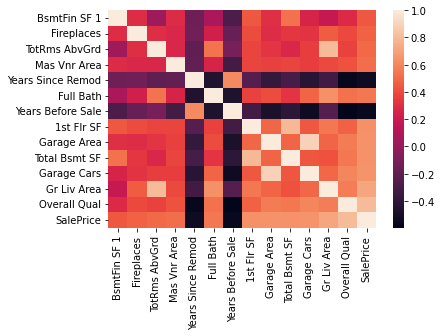

In [87]:
import seaborn as sns
data_transform = transform_features(sale_houses)
seri_corr = np.abs(data_transform.corr()['SalePrice'])
corr_strong = seri_corr[seri_corr>0.4].sort_values()
name_numeric_cols = corr_strong.index
max_corr = data_transform.loc[:,corr_strong.index].corr()
sns.heatmap(max_corr)

In [88]:
#từ heatmap ở trên thấy có 3 cặp feature tương đồng lẫn nhau, nên xóa đi 1 từ mỗi cặp
name_numeric_cols = name_numeric_cols.drop(['Garage Area','Total Bsmt SF','TotRms AbvGrd'])
name_numeric_cols

Index(['BsmtFin SF 1', 'Fireplaces', 'Mas Vnr Area', 'Years Since Remod',
       'Full Bath', 'Years Before Sale', '1st Flr SF', 'Garage Cars',
       'Gr Liv Area', 'Overall Qual', 'SalePrice'],
      dtype='object')

2. Lọc text_cloumn với tiêu chí số gtri duy nhất < 10. Bởi vì bước sau convert category column sang dạng dummy (mã giả code)

In [89]:
# Đếm số lượng value unique tại mỗi cột
name_text_cols = data_transform.select_dtypes(include = 'object').columns
count_unique = data_transform[name_text_cols].apply(lambda col: len(col.unique()))
count_unique

MS Zoning        7
Street           2
Lot Shape        4
Land Contour     4
Utilities        3
Lot Config       5
Land Slope       3
Neighborhood    28
Condition 1      9
Condition 2      8
Bldg Type        5
House Style      8
Roof Style       6
Roof Matl        8
Exterior 1st    16
Exterior 2nd    17
Exter Qual       4
Exter Cond       5
Foundation       6
Heating          6
Heating QC       5
Central Air      2
Kitchen Qual     5
Functional       8
Paved Drive      3
dtype: int64

In [90]:
#drop những column có số unique >10
name_text_cols = name_text_cols.drop(count_unique[count_unique>10].index)
name_text_cols

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Roof Style', 'Roof Matl', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Heating', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Paved Drive'],
      dtype='object')

In [91]:
# tạo 1 df mới với những column đã lọc đc ở trên
name_cols_full = name_numeric_cols.to_list()  + name_text_cols.to_list()
data_transform = data_transform[name_cols_full]
data_transform.head()

,BsmtFin SF 1,Fireplaces,Mas Vnr Area,Years Since Remod,Full Bath,Years Before Sale,1st Flr SF,Garage Cars,Gr Liv Area,Overall Qual,...,Roof Matl,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,Kitchen Qual,Functional,Paved Drive
0,639.0,2,112.0,50,1,50,1656,2.0,1656,6,...,CompShg,TA,TA,CBlock,GasA,Fa,Y,TA,Typ,P
1,468.0,0,0.0,49,1,49,896,1.0,896,5,...,CompShg,TA,TA,CBlock,GasA,TA,Y,TA,Typ,Y
2,923.0,0,108.0,52,1,52,1329,1.0,1329,6,...,CompShg,TA,TA,CBlock,GasA,TA,Y,Gd,Typ,Y
3,1065.0,2,0.0,42,2,42,2110,2.0,2110,7,...,CompShg,Gd,TA,CBlock,GasA,Ex,Y,Ex,Typ,Y
4,791.0,1,0.0,12,2,13,928,2.0,1629,5,...,CompShg,TA,TA,PConc,GasA,Gd,Y,TA,Typ,Y


In [92]:
name_text_col = data_transform.select_dtypes(include = 'object').columns
for col in name_text_col:
    data_transform[col] = data_transform[col].astype('category')
data_transform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   BsmtFin SF 1       2927 non-null   float64 
 1   Fireplaces         2927 non-null   int64   
 2   Mas Vnr Area       2927 non-null   float64 
 3   Years Since Remod  2927 non-null   int64   
 4   Full Bath          2927 non-null   int64   
 5   Years Before Sale  2927 non-null   int64   
 6   1st Flr SF         2927 non-null   int64   
 7   Garage Cars        2927 non-null   float64 
 8   Gr Liv Area        2927 non-null   int64   
 9   Overall Qual       2927 non-null   int64   
 10  SalePrice          2927 non-null   int64   
 11  MS Zoning          2927 non-null   category
 12  Street             2927 non-null   category
 13  Lot Shape          2927 non-null   category
 14  Land Contour       2927 non-null   category
 15  Utilities          2927 non-null   category
 16  Lot Co

In [93]:
#tạo mã giả (dummy) và bỏ đi các category column
data_transform = pd.concat([data_transform, pd.get_dummies(data_transform.select_dtypes(include = 'category'))],axis = 1)              

In [94]:
#bỏ đi các category column
data_transform = data_transform.drop(name_text_col, axis = 1)
data_transform.head()   

,BsmtFin SF 1,Fireplaces,Mas Vnr Area,Years Since Remod,Full Bath,Years Before Sale,1st Flr SF,Garage Cars,Gr Liv Area,Overall Qual,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,639.0,2,112.0,50,1,50,1656,2.0,1656,6,...,0,0,0,0,0,0,1,0,1,0
1,468.0,0,0.0,49,1,49,896,1.0,896,5,...,0,0,0,0,0,0,1,0,0,1
2,923.0,0,108.0,52,1,52,1329,1.0,1329,6,...,0,0,0,0,0,0,1,0,0,1
3,1065.0,2,0.0,42,2,42,2110,2.0,2110,7,...,0,0,0,0,0,0,1,0,0,1
4,791.0,1,0.0,12,2,13,928,2.0,1629,5,...,0,0,0,0,0,0,1,0,0,1


Update select_features()

In [40]:
def transform_features(df):
    seri_null_counts = df.isnull().sum()
    index_null_than5 = seri_null_counts[seri_null_counts>(len(sale_houses)/20)].index
    drop_null_than5 = df.drop(columns = index_null_than5, axis = 1)
    
    text_null_counts = drop_null_than5.select_dtypes(include = 'object').isnull().sum()
    text_null_index = text_null_counts[text_null_counts > 0].index
    data = drop_null_than5.drop(columns =text_null_index, axis = 1 )
    
    cols_num = data.select_dtypes(include = ['float','int']).columns
    data.loc[:,cols_num] = data.loc[:,cols_num].fillna(data.loc[:,cols_num].mean())
    

    data['Years Before Sale'] = data['Yr Sold'] - data['Year Built']
    age_error = data['Years Before Sale'][data['Years Before Sale']<0].index.to_list()
    data['Years Since Remod'] = data['Yr Sold'] - data['Year Remod/Add']
    remod_error = data['Years Since Remod'][data['Years Since Remod'] <0].index.to_list()
    list_error = list(set(age_error + remod_error))
    

    data = data.drop(list_error, axis =0)
    data = data.drop(["Year Built", "Year Remod/Add","PID","Order","Mo Sold","Sale Condition","Sale Type","Yr Sold"],axis = 1)
    return data

def select_features(df, corr_threshold = 0.4 , num_unique = 10):
    import seaborn as sns
    data_transform = df.copy()
    seri_corr = np.abs(data_transform.corr()['SalePrice'])
    corr_strong = seri_corr[seri_corr>corr_threshold].sort_values()
    max_corr = data_transform.loc[:,corr_strong.index].corr()
    #print(sns.heatmap(max_corr))
    
    name_numeric_cols = corr_strong.index
    name_numeric_cols = name_numeric_cols.drop(['Garage Area','Total Bsmt SF','TotRms AbvGrd'])
    name_text_cols = data_transform.select_dtypes(include = 'object').columns
    count_unique = data_transform[name_text_cols].apply(lambda col: len(col.unique()))
    name_text_cols = name_text_cols.drop(count_unique[count_unique>num_unique].index)
    
    name_cols_full = name_numeric_cols.to_list()  + name_text_cols.to_list()
    data_transform = data_transform[name_cols_full]
        
    #tạo mã giả (dummy)
    data_transform = pd.concat([data_transform, 
                            pd.get_dummies(data_transform.select_dtypes(include = 'object'))],axis = 1) 
    
    #bỏ đi các category column
    data_transform = data_transform.drop(name_text_cols, axis = 1)
    
    
    return data_transform

def train_and_test(df,k):
    from sklearn.metrics import mean_squared_error
    '''
    Nếu chia data thành 2 tệp train, test theo % cố định(ví dụ train: 0 > 1460,test: 1460 > hết) ko phải khôn ngoan , bởi vì:
    - chia như vậy ta thực sự không biết khoảng dữ liệu nào thực sự tốt và tối ưu cho việc train model.
    - Giải pháp là sử dụng xác thực chéo (cross-validation)
    '''
    if k == 0 :
        train = df[0:1460].copy()
        test = df[1460:].copy()

        X_train = train.drop(['SalePrice'], axis = 1)
        y_train = train['SalePrice']

        lr = LinearRegression()
        lr.fit(X_train, y_train)

        X_test = test.drop(['SalePrice'], axis = 1)
        y_test = test['SalePrice']

        y_predict = lr.predict(X_test)

        mse_test = mean_squared_error(y_predict,y_test)
        rmse_test = np.sqrt(mse_test)
        return rmse_test
    elif k ==1 :
        random_df = df.sample(frac = 1)
        train = random_df[0:1460].copy()
        test = random_df[1460:].copy()

        X_train = train.drop(['SalePrice'], axis = 1)
        y_train = train['SalePrice']

        lr = LinearRegression()
        lr.fit(X_train, y_train)

        X_test = test.drop(['SalePrice'], axis = 1)
        y_test = test['SalePrice']

        y_predict = lr.predict(X_test)

        mse_test = mean_squared_error(y_predict,y_test)
        rmse_test = np.sqrt(mse_test)
        return rmse_test

    elif k >=2:
        features = df.columns.drop(['SalePrice'])
        from sklearn.model_selection import KFold
        kf = KFold(n_splits = k, shuffle = True)
        list_rmse = []
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index,:]
            test = df.iloc[test_index,:]
            lr = LinearRegression()
            lr.fit(train[features], train['SalePrice'])
            y_predict = lr.predict(test[features])
            rmse = mean_squared_error(y_predict,test['SalePrice'])**(1/2)
            list_rmse.append(rmse)  
        return list_rmse

sale_houses = pd.read_csv('AmesHousing.txt',delimiter = '\t')
trans_data = transform_features(sale_houses)
df_filtered = select_features(trans_data, 0.4,10)

dict_rmse = {}
for k in range(0,6):
    dict_rmse[k] = train_and_test(df_filtered,k)
    
print(dict_rmse)

{0: 32906.472551015206, 1: 26508.258499058367, 2: [30967.65734598641, 28943.76712500004], 3: [26810.082403692337, 34411.185516887774, 26336.24693820561], 4: [28070.082740412727, 29586.25658509902, 29057.296453983454, 32432.097767351093], 5: [25567.879749582655, 27612.075173497113, 25661.84883470209, 38214.78926430373, 25928.18741506125]}
